<a href="https://colab.research.google.com/github/nguyenhoanganh2002/Multi-label-Image-Classification/blob/main/multi_labels_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from PIL import Image

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Read anotation**

In [3]:
training_anot = pd.read_csv('/content/drive/MyDrive/multilabels_data/trainset/labels.csv')
testing_anot = pd.read_csv('/content/drive/MyDrive/multilabels_data/testset/labels.csv')

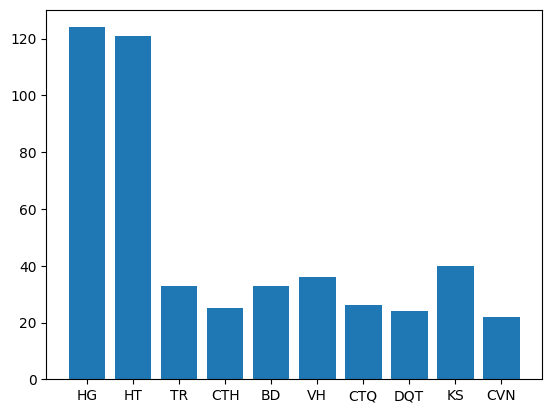

In [4]:
# Class Distribution Visualization
def stat(anot):
    statistic = {"HG": sum(anot["HG"]), "HT": sum(anot["HT"]), "TR": sum(anot["TR"]), "CTH": sum(anot["CTH"]), "BD": sum(anot["BD"]),
                "VH": sum(anot["VH"]), "CTQ": sum(anot["CTQ"]), "DQT": sum(anot["DQT"]), "KS": sum(anot["KS"]), "CVN": sum(anot["CVN"])}
    plt.bar(list(statistic.keys()), list(statistic.values()))

stat(training_anot)

# **Custom DataLoader**

In [5]:
class CustomDataset(Dataset):
    def __init__(self, anot, transforms=None, training=True):
        super().__init__()
        self.anot = anot
        self.transforms = transforms
        self.training = training

    def __len__(self):
        return len(self.anot)

    def __getitem__(self, idx):
        if self.training:
            img_path = "/content/drive/MyDrive/multilabels_data/trainset/" + self.anot['name'][idx]
        else:
            img_path = "/content/drive/MyDrive/multilabels_data/testset/" + self.anot['name'][idx]

        label = torch.tensor(self.anot.iloc[idx][1:]).type(torch.FloatTensor)
        image = Image.open(img_path)
        
        if self.transforms:
            image = torch.tensor(self.transforms(image).float())
            
        return image, label

In [7]:
# define transforms and generate dataloader
trans = transforms.Compose([
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])

traindataset = CustomDataset(training_anot, transforms=trans)
valdataset = CustomDataset(testing_anot, transforms=trans, training=False)
trainloader = DataLoader(dataset=traindataset, batch_size=64, shuffle=True)
valloader = DataLoader(dataset=valdataset, batch_size=64, shuffle=True)

# **Fine tuning pretrained model**

### Load pretrained model

In [19]:
from torchvision import models
net = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# print(net)

### Fine-tune

In [20]:
from torch.nn.modules.activation import Sigmoid
net.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 10),
    nn.Sigmoid()
)

In [ ]:
# print(net)

In [21]:
# select param to update
def params_to_update(net):
    params_to_update_1 = []
    params_to_update_2 = []
    params_to_update_3 = []

    for name, param in net.named_parameters():

        if "conv1" in name:
            # print(name)
            param.requires_grad = True
            params_to_update_1.append(param)
        elif ("layer1" in name) or ("layer2" in name) or ("layer3" in name) or ("layer4" in name):
            param.requires_grad = True
            params_to_update_2.append(param)
        else:
            param.requires_grad = True
            params_to_update_3.append(param)

    return params_to_update_1, params_to_update_2, params_to_update_3

### define optimizer and loss function

In [22]:
param1, param2, param3 = params_to_update(net)

optimizer = optim.Adam([{'params': param1, 'lr': 0.00001},
                        {'params': param2, 'lr': 0.00005},
                        {'params': param3, 'lr': 0.0001}])

loss_func = nn.BCELoss()


# **Train**

In [30]:
epochs = 50 # The total number of iterations
threshold = 0.5

min_val_loss = 1e9
train_losses = []
val_losses = []

net = net.to(device)

for epoch in range(epochs):
    # prep model for training
    net.train()
    train_loss = 0

    for images, labels in trainloader: 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = net(images)
        loss = loss_func(output, labels)
        # loss.requires_grad = True

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        net.eval() 
        val_loss = 0
        accuracy = 0

        # Turn off the gradients when performing validation.
        # If we don't turn it off, we will comprise our networks weight entirely
        with torch.no_grad():
            for images, labels in valloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                outs = net(images)
                # print(log_probabilities.shape, labels.shape)
                # print(log_probabilities[0], labels[0])
                val_loss += loss_func(outs, labels)
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    torch.save(net, '/content/drive/MyDrive/multilabels_data/model.pth')

                out_labels = (outs >= threshold).type(torch.IntTensor)
                out_labels = out_labels.to(device)
                predictions = out_labels == labels.view(out_labels.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        val_losses.append(val_loss.cpu()/len(valloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "val loss: {:.4f}  ".format(val_loss/len(valloader)),
              "val accuracy: {:.4f}  ".format(accuracy/len(valloader)))

<ipython-input-5-bdd1540f013a>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.transforms(image).float())


Epoch: 1/5   Training loss: 0.0001   val loss: 0.2086   val accuracy: 0.9503  
Epoch: 2/5   Training loss: 0.0001   val loss: 0.2367   val accuracy: 0.9469  
Epoch: 3/5   Training loss: 0.0001   val loss: 0.1988   val accuracy: 0.9588  
Epoch: 4/5   Training loss: 0.0001   val loss: 0.2807   val accuracy: 0.9377  
Epoch: 5/5   Training loss: 0.0001   val loss: 0.3213   val accuracy: 0.9461  


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train losses")
plt.plot(val_losses, label="val losses")
plt.legend();

# **Evaluation**

In [35]:
model = torch.load('/content/drive/MyDrive/multilabels_data/model.pth')

In [36]:
def predict(imgPath):
    trans4test = transforms.Compose([
                                    transforms.Resize(240),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
    threshold = 0.5
    with torch.no_grad():
        raw_image = Image.open(imgPath)
        trans_image = trans4test(raw_image)
        trans_image = trans_image.to(device)

        outs = model(trans_image[None])
        out_labels = (outs >= threshold).type(torch.IntTensor)
        
        trans_image = trans_image.to('cpu')
        out_labels = out_labels.to('cpu')

        plt.imshow(raw_image, cmap='inferno')

        labels = ["Hồ Gươm", "Hồ Tây", "Tháp Rùa", "Cầu Thê Húc", "Bưu Điện", "Vườn Hoa", "Chùa Trấn Quốc", "Đền Quán Thánh", "Khách Sạn", "Công Viên Nước"]
        res = []
        for i in range(len(out_labels[0])):
            if out_labels[0][i] == 1:
                res.append(labels[i])
        print(f'{res}\n')

['Hồ Tây', 'Đền Quán Thánh']



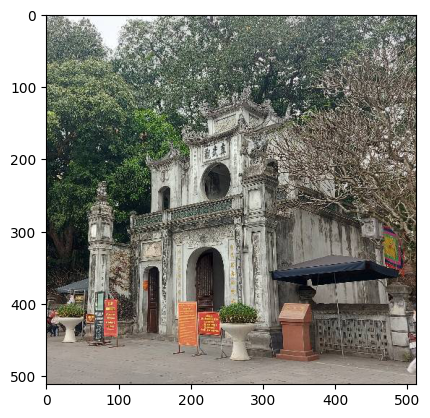

In [46]:
import random
import getch
testImg = random.choice([_ for _ in range(1, 75)])
predict("/content/drive/MyDrive/multilabels_data/testset/" + f'{testImg}.jpg')